In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches,patheffects

torch.cuda.set_device(0)

## Pascal VOC

We will be looking at the [Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/) dataset. It's quite slow, so you may prefer to download from [this mirror](https://pjreddie.com/projects/pascal-voc-dataset-mirror/). There are two different competition/research datasets, from 2007 and 2012. We'll be using the 2007 version. You can use the larger 2012 for better results, or even combine them (but be careful to avoid data leakage between the validation sets if you do this).

Unlike previous lessons, we are using the python 3 standard library `pathlib` for our paths and file access. Note that it returns an OS-specific class (on Linux, `PosixPath`) so your output may look a little different. Most libraries than take paths as input can take a pathlib object - although some (like `cv2`) can't, in which case you can use `str()` to convert it to a string.

In [4]:
PATH = Path('/fastai/data/pascal')

In [9]:
list(PATH.iterdir())

[PosixPath('/fastai/data/pascal/VOCdevkit'),
 PosixPath('/fastai/data/pascal/pascal_test2007.json'),
 PosixPath('/fastai/data/pascal/pascal_train2007.json'),
 PosixPath('/fastai/data/pascal/pascal_train2012.json'),
 PosixPath('/fastai/data/pascal/pascal_val2007.json'),
 PosixPath('/fastai/data/pascal/pascal_val2012.json')]

In [16]:
str(PATH)

'/fastai/data/pascal'

As well as the images, there are also *annotations* - *bounding boxes* showing where each object is. These were hand labeled. The original version were in XML, which is a little hard to work with nowadays, so we uses the more recent JSON version which you can download from [this link](https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip).

You can see here how `pathlib` includes the ability to open files (amongst many other capabilities).

In [17]:
trn_j =  json.load((PATH/'pascal_train2007.json').open())
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [18]:
IMAGES, ANNOTATIONS, CATEGORIES = ['images', 'annotations', 'categories'] #just names in variables for easy reference
trn_j[IMAGES][:5] #first 5 images

[{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12},
 {'file_name': '000017.jpg', 'height': 364, 'width': 480, 'id': 17},
 {'file_name': '000023.jpg', 'height': 500, 'width': 334, 'id': 23},
 {'file_name': '000026.jpg', 'height': 333, 'width': 500, 'id': 26},
 {'file_name': '000032.jpg', 'height': 281, 'width': 500, 'id': 32}]

In [20]:
trn_j[ANNOTATIONS][:2]

[{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
  'area': 34104,
  'iscrowd': 0,
  'image_id': 12,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0},
 {'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]],
  'area': 13110,
  'iscrowd': 0,
  'image_id': 17,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0}]

In [21]:
trn_j[CATEGORIES][:4]

[{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'},
 {'supercategory': 'none', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'none', 'id': 3, 'name': 'bird'},
 {'supercategory': 'none', 'id': 4, 'name': 'boat'}]

It's helpful to use constants instead of strings, since we get tab-completion and don't mistype

In [22]:
FILE_NAME,NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','name','id','image_id','category_id','bbox'

cats = {o[ID]:o[NAME] for o in trn_j[CATEGORIES]}
trn_fns = {o[ID]:o[FILE_NAME] for o in trn_j[IMAGES]}
trn_ids = [o[ID] for o in trn_j[IMAGES]]

In [23]:
list((PATH/'VOCdevkit'/'VOC2007').iterdir())

[PosixPath('/fastai/data/pascal/VOCdevkit/VOC2007/Annotations'),
 PosixPath('/fastai/data/pascal/VOCdevkit/VOC2007/ImageSets'),
 PosixPath('/fastai/data/pascal/VOCdevkit/VOC2007/JPEGImages'),
 PosixPath('/fastai/data/pascal/VOCdevkit/VOC2007/SegmentationClass'),
 PosixPath('/fastai/data/pascal/VOCdevkit/VOC2007/SegmentationObject')]

In [25]:
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'

In [26]:
IMG_PATH = PATH/JPEGS
list(IMG_PATH.iterdir())[:5]

[PosixPath('/fastai/data/pascal/VOCdevkit/VOC2007/JPEGImages/000005.jpg'),
 PosixPath('/fastai/data/pascal/VOCdevkit/VOC2007/JPEGImages/000007.jpg'),
 PosixPath('/fastai/data/pascal/VOCdevkit/VOC2007/JPEGImages/000009.jpg'),
 PosixPath('/fastai/data/pascal/VOCdevkit/VOC2007/JPEGImages/000012.jpg'),
 PosixPath('/fastai/data/pascal/VOCdevkit/VOC2007/JPEGImages/000016.jpg')]

Each images has a unique ID.

In [27]:
im0_d = trn_j[IMAGES][0]
im0_d[FILE_NAME], im0_d[ID]

('000012.jpg', 12)

A `defaultdict` is useful any time you want to have a default dictionary entry for new keys. Here we create a dict from image IDs to a list of annotations (tuple of bounding box and class id).

We convert VOC's height/width into top-left/bottom-right, and switch x/y coords to be consistent with numpy.

`bb[0],bb[1],bb[2],bb[3]` represent x,y,w,h respectively. We conver that into
y,x, h+y -1, w+x -1 which relates to top-left(x,y) and bottom-right(x',y') respectively


In [29]:
def hw_bb(bb): return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])

trn_anno = collections.defaultdict(lambda:[]) # initialize with an empty array so append can be called as in below
for o in trn_j[ANNOTATIONS]:
    if not o['ignore']:
        bb = o[BBOX]
        bb = hw_bb(bb)
        trn_anno[o[IMG_ID]].append((bb,o[CAT_ID]))
len(trn_anno)

2501

In [30]:
im_a = trn_anno[im0_d[ID]]; im_a

[(array([ 96, 155, 269, 350]), 7)]

In [31]:
im0_a = im_a[0];im0_a

(array([ 96, 155, 269, 350]), 7)

In [32]:
cats[7]

'car'

In [34]:
trn_anno[17]

[(array([ 61, 184, 198, 278]), 15), (array([ 77,  89, 335, 402]), 13)]

In [35]:
cats[15], cats[13]

('person', 'horse')

Some libs take VOC format bounding boxes, so this let's us convert back when required:

In [36]:
bb_voc = [155,96,196,174]
bb_fastai =  hw_bb(bb_voc)
bb_fastai

array([ 96, 155, 269, 350])

In [40]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

In [41]:
f'expected: {bb_voc}, actual: {bb_hw(bb_fastai)}'

'expected: [155, 96, 196, 174], actual: [155  96 196 174]'

You can use [Visual Studio Code](https://code.visualstudio.com/) (vscode - open source editor that comes with recent versions of Anaconda, or can be installed separately), or most editors and IDEs, to find out all about the `open_image` function. vscode things to know:

- Command palette (<kbd>Ctrl-shift-p</kbd>)
- Select interpreter (for fastai env)
- Select terminal shell
- Go to symbol (<kbd>Ctrl-t</kbd>)
- Find references (<kbd>Shift-F12</kbd>)
- Go to definition (<kbd>F12</kbd>)
- Go back (<kbd>alt-left</kbd>)
- View documentation
- Hide sidebar (<kbd>Ctrl-b</kbd>)
- Zen mode (<kbd>Ctrl-k,z</kbd>)

In [57]:
im = open_image(str(IMG_PATH/im0_d[FILE_NAME]))

Matplotlib's `plt.subplots` is a really useful weapper for creating plots, regardless of whether you have more than one subplot. Note that Matplotlib has an optional object-oriented API which is much easier to understand and use (although few examples online use it!)

In [58]:
def show_img(im, figsize= None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)# create ax with subplots if None
    ax.imshow(im)
    ax.get_xaxis().set_visible(False) #dont show the x and y axis with markers as in for data
    ax.get_yaxis().set_visible(False)
    return ax

A simple but rarely used trick to making text visible regardless of background is to use white text with black outline, or vice versa. Here is how to do it in matplotlib.

In [59]:
def draw_outline(o,lw):
    o.set_path_effects([patheffects.Stroke(linewidth=lw, foreground='black'), patheffects.Normal()])

Note that `*` in argument lists is the [splat operator](https://stackoverflow.com/questions/5239856/foggy-on-asterisk-in-python). In this case it's a little shortcut compared to writing out `b[-2],b[-1]`.

In [60]:
def draw_rect(ax,b):
    patch =  ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [61]:
def draw_text(ax,xy,txt,sz=14):
    text = ax.text(*xy,txt,verticalalignment='top',color='white',fontsize=sz,weight='bold')
    draw_outline(text,1)

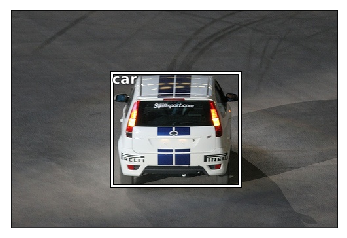

In [62]:
ax = show_img(im)
b = bb_hw(im0_a[0])
draw_rect(ax,b)
draw_text(ax,b[:2],cats[im0_a[1]])

In [63]:
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b =  bb_hw(b)
        draw_rect(ax,b)
        draw_text(ax,b[:2],cats[c],sz=16)

In [68]:
def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(str(IMG_PATH/trn_fns[i]))
    print(im.shape)
    draw_im(im, im_a)

(364, 480, 3)


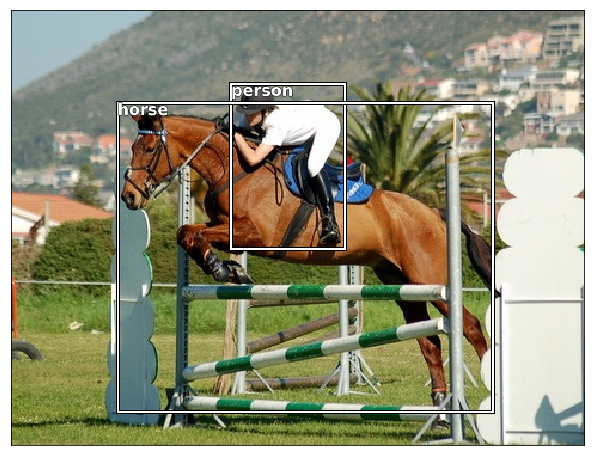

In [69]:
draw_idx(17)

## Largest item classifier

A lambda function is simply a way to define an anonymous function inline. Here we use it to describe how to sort the annotation for each image - by bounding box size (descending).

In [78]:
def get_lrg(b):
    if not b: raise Exception()
    b =  sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]

In [79]:
trn_lrg_anno =  {a: get_lrg(b) for a,b in trn_anno.items()}

Now we have a dictionary from image id to a single bounding box - the largest for that image.

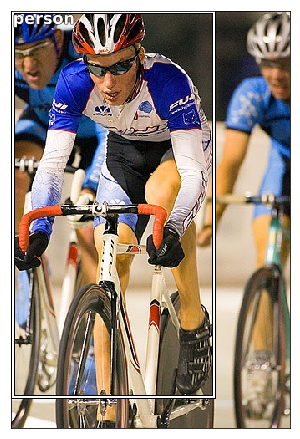

In [80]:
b,c = trn_lrg_anno[23]
b = bb_hw(b)
ax = show_img(open_image(str(IMG_PATH/trn_fns[23])), figsize=(5,10))
draw_rect(ax,b)
draw_text(ax,b[:2],cats[c],sz=16)

In [87]:
(PATH/'tmp').mkdir()
CSV =  PATH/'tmp/lrg.csv'

Often it's easiest to simply create a CSV of the data you wnat to model, rathern than trying to create a custom dataset. Here we use Pandas to help us create a CSV of the image filename and class.

In [88]:
df = pd.DataFrame({'fn':[trn_fns[o] for o in trn_ids],
     'cat':[cats[trn_lrg_anno[o][1]] for o in trn_ids]},columns=['fn','cat'])
df.to_csv(CSV, index=False)

In [91]:
f_model =  resnet34
sz = 224
bs = 64

From here it's just like Dogs vs Cats!

In [97]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(str(PATH),JPEGS,str(CSV), tfms=tfms, bs=bs)


In [98]:
x,y = next(iter(md.val_dl))

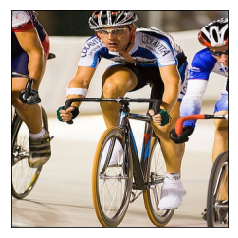

In [99]:
show_img(md.val_ds.denorm(to_np(x))[0])

In [100]:
learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy])
learn.opt_fn = optim.Adam

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:03<00:00, 22846971.86it/s]


In [101]:
lrf = learn.lr_find(1e-5,100)

 75%|███████▌  | 24/32 [00:13<00:04,  1.76it/s, loss=3.91]

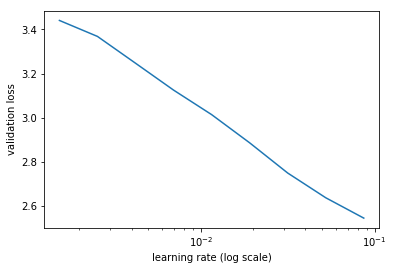

In [102]:
learn.sched.plot()

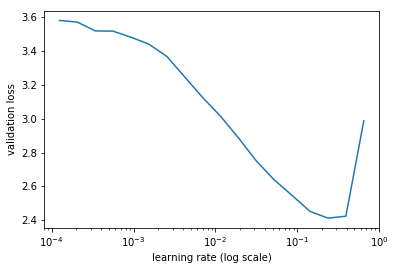

In [103]:
learn.sched.plot(n_skip=5,n_skip_end=1)

In [104]:
lr = 2e-2

In [105]:
learn.fit(lr, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                 
    0      1.270028   0.644147   0.804     


[0.6441474235057831, 0.8040000023841858]

In [106]:
lrs = np.array([lr/1000,lr/100,lr])

In [107]:
learn.freeze_to(-2)

 84%|████████▍ | 27/32 [00:12<00:02,  2.12it/s, loss=2.43] 

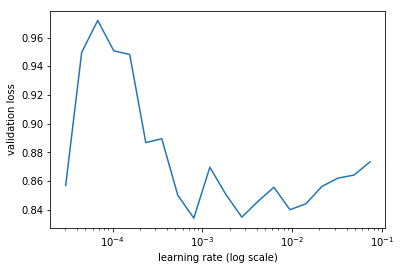

In [108]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [109]:
learn.fit(lrs/5, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.809928   0.581341   0.824     


[0.5813405253887176, 0.8240000038146973]

In [110]:
learn.unfreeze()

Accuracy isn't improving much - since many images have multiple different objects, its going to be impossible to be that accurate.

In [111]:
learn.fit(lrs/5, 1, cycle_len= 2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.642206   0.580064   0.814     
    1      0.444145   0.542407   0.828                     


[0.5424074158668518, 0.8280000038146973]

In [112]:
learn.save('class_one')

In [113]:
learn.load('class_one')

In [114]:
x,y = next(iter(md.val_dl))
probs =  F.softmax(predict_batch(learn.model,x), -1)
x,preds =  to_np(x), to_np(probs)
preds =  np.argmax(preds, -1)

You can use the python debugger `pdb` to step through code.

- `pdb.set_trace()` to set a breakpoint
- `%debug` magic to trace an error

Commands you need to know:

- s / n / c
- u / d
- p
- l

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


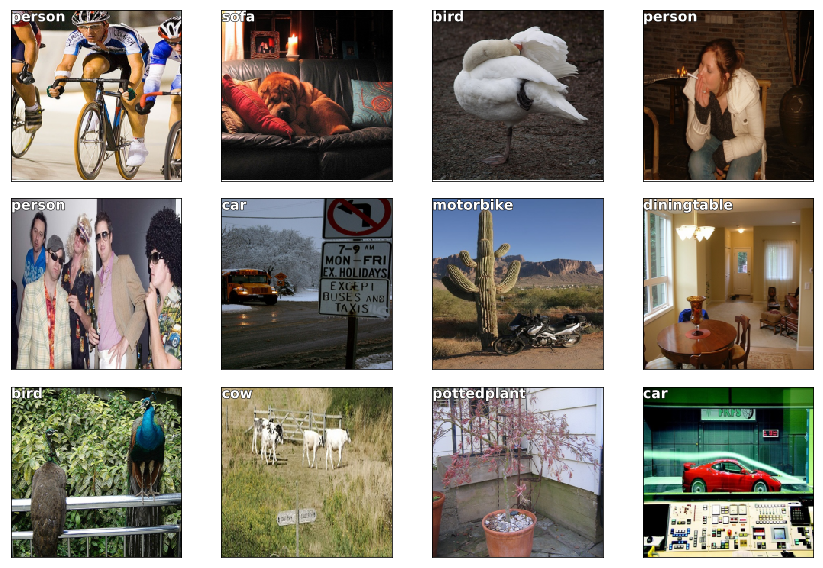

In [116]:
fig, axes = plt.subplots(3,4, figsize=(12,8))
for i,ax in enumerate(axes.flat):
    ima = md.val_ds.denorm(x)[i]
    b = md.classes[preds[i]]
    ax = show_img(ima,ax=ax)
    draw_text(ax,(0,0),b)
plt.tight_layout()

It's doing a pretty good job of classifying the largest object!.

## Bbox only

Now we'll try to find the bounding box of the largest object. This is simply a regression with 4 outputs. So we can use a CSV with multiple 'labels'.

In [117]:
BB_CSV =  PATH/'tmp/bb.csv'

In [118]:
bb = np.array([trn_lrg_anno[o][0] for o in trn_ids])
bbs = [' '.join(str(p) for p in o) for o in bb ]

df = pd.DataFrame({'fn':[trn_fns[o] for o in trn_ids], 'bbox': bbs}, columns=['fn','bbox'])
df.to_csv(BB_CSV, index=False)

In [119]:
BB_CSV.open().readlines()[:5]

['fn,bbox\n',
 '000012.jpg,96 155 269 350\n',
 '000017.jpg,77 89 335 402\n',
 '000023.jpg,1 2 461 242\n',
 '000026.jpg,124 89 211 336\n']

In [120]:
f_model=resnet34
sz=224
bs=64

Set `continuos=True` to tell fastai this is a regression problem, which means it won't one-hot encode the labels, and will use MSE as the default crit.

Note that we have to tell the transforms constructor that our labels are coordinates, so that it can handle the transforms correctly.

Also, we use CropType. NO because we want to 'squish' the rectangular images into squares, rather than center cropping, so that we don't accidentally crop out some of the objects. (This is less of an issue in something like imagenet, where there is a single object to classify, and its generally large and centrally located).

In [121]:
augs =  [RandomFlip(), RandomRotate(30), RandomLighting(0.1,0.1)]

In [123]:
tfms =  tfms_from_model(f_model,sz,crop_type=CropType.NO, aug_tfms=augs)
md = ImageClassifierData.from_csv(str(PATH),JPEGS,str(BB_CSV),tfms=tfms,continuous=True, bs=4)

[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]


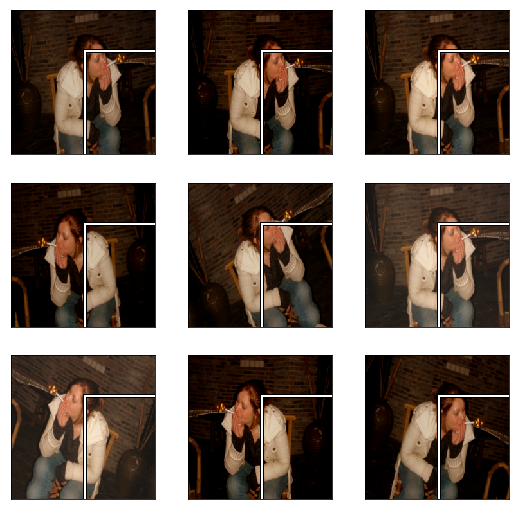

In [124]:
idx=3
fig,axes = plt.subplots(3,3,figsize=(9,9))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(md.aug_dl))
    ima=md.val_ds.denorm(to_np(x))[idx]
    b = bb_hw(to_np(y[idx]))
    print(b)
    show_img(ima,ax=ax)
    draw_rect(ax,b)

In [125]:
augs = [RandomFlip(tfm_y=TfmType.COORD), 
        RandomRotate(30,tfm_y=TfmType.COORD), 
        RandomLighting(0.1,0.1,tfm_y=TfmType.COORD)]

In [126]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)
md = ImageClassifierData.from_csv(str(PATH),JPEGS,str(BB_CSV),tfms=tfms, continuous=True, bs=64)

[ 52.  38. 106. 183.]
[ 36.  21. 149. 202.]
[ 20.   8. 159. 215.]
[ 66.  38. 105. 183.]
[ 45.  24. 139. 199.]
[ 59.  33. 117. 190.]
[ 35.  20. 151. 203.]
[ 46.  31. 122. 192.]
[ 32.  17. 159. 206.]


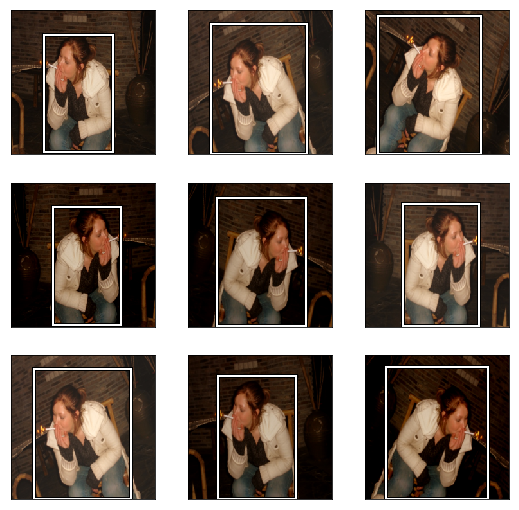

In [127]:
idx=3
fig,axes  = plt.subplots(3,3, figsize=(9,9))
for i,ax in enumerate(axes.flat):
    x,y = next(iter(md.aug_dl))
    ima=md.val_ds.denorm(to_np(x))[idx]
    b = bb_hw(to_np(y[idx]))
    print(b)
    show_img(ima, ax=ax)
    draw_rect(ax,b)

In [128]:
tfm_y = TfmType.COORD
augs = [RandomFlip(tfm_y=tfm_y),
        RandomRotate(3, p=0.5, tfm_y=tfm_y),
        RandomLighting(0.05,0.05, tfm_y=tfm_y)]

tfms =  tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=tfm_y, aug_tfms=augs)
md = ImageClassifierData.from_csv(str(PATH),JPEGS, str(BB_CSV), tfms=tfms, bs=bs, continuous=True)

fastai let's you use a `custom_head` to add your own module on top of a convnet, instead of the adaptive pooling and fully connected net which is added by default. In this case, we don't want to do any pooling, since we need to know the activations of each grid cell.

The final layer has 4 activations, one per bounding box coordinate. Our target is continuous, not categorical, so the MSE loss function used does not do any sigmoid or softmax to the module outputs.

In [129]:
512*7*7

25088

In [130]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088,4))
learn = ConvLearner.pretrained(f_model,md,custom_head=head_reg4)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

In [131]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', tensor(9408))])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', tensor(128))])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape

 78%|███████▊  | 25/32 [00:15<00:04,  1.57it/s, loss=369] 

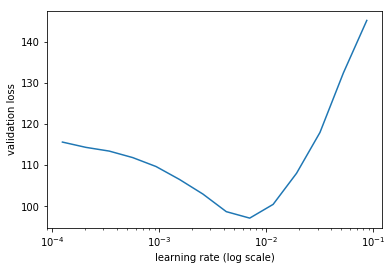

In [132]:
learn.lr_find(1e-5,100)
learn.sched.plot(5)

In [133]:
lr = 2e-3

In [134]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                            
    0      48.053402  34.188945 
    1      36.358503  28.129173                           
    2      31.118113  27.569091                           


[27.5690908203125]

In [135]:
lrs = np.array([lr/100,lr/10,lr])

In [136]:
learn.freeze_to(-2)

epoch      trn_loss   val_loss                            
    0      60.267382  1.8629254826302636e+16


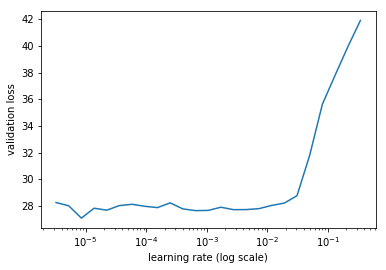

In [137]:
lrf = learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [138]:
learn.fit(lrs,2,cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                            
    0      25.90444   22.772336 
    1      23.378116  21.618285                           
    2      20.001227  19.701596                           


[19.701595916748047]

In [139]:
learn.freeze_to(-3)

In [140]:
learn.fit(lrs,1, cycle_len=2)

epoch      trn_loss   val_loss                            
    0      19.282245  21.133568 
    1      17.04167   19.633655                           


[19.633655303955077]

In [141]:
learn.fit(lrs,2,cycle_len=2)

epoch      trn_loss   val_loss                            
    0      17.373785  20.728393 
    1      15.169344  19.419415                           
    2      15.086653  19.990628                           
    3      13.450303  18.650682                           


[18.650682083129883]

In [142]:
learn.save('reg4')

In [143]:
learn.load('reg4')

In [144]:
x,y = next(iter(md.val_dl))
learn.model.eval()
preds =  to_np(learn.model(VV(x)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


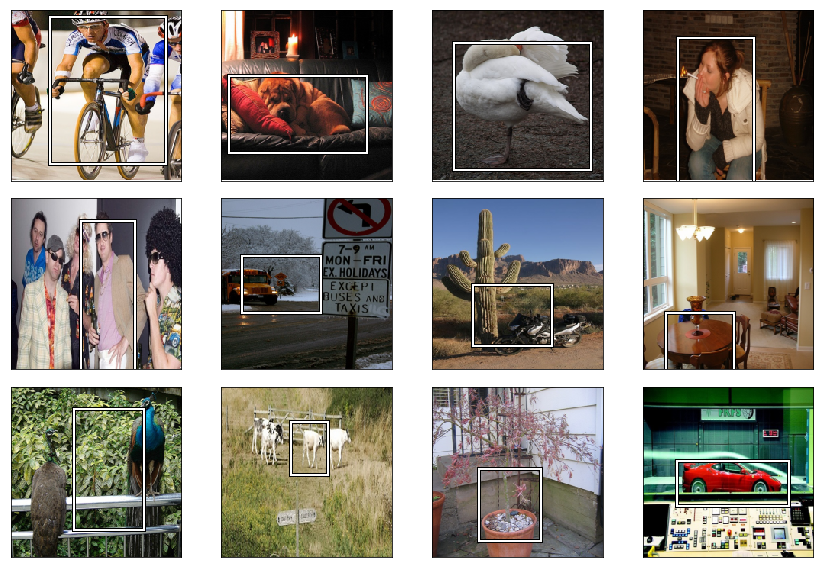

In [145]:
fig, axes = plt.subplots(3,4, figsize=(12,8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(to_np(x))[i]
    b = bb_hw(preds[i])
    ax = show_img(ima,ax=ax)
    draw_rect(ax,b)
plt.tight_layout()

## Single object detection

In [146]:
f_model = resnet34
sz=224
bs=64

val_idxs = get_cv_idxs(len(trn_fns))

In [147]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)
md = ImageClassifierData.from_csv(str(PATH),JPEGS,str(BB_CSV), tfms=tfms,
          bs=bs, continuous=True, val_idxs=val_idxs)

In [150]:
md2 =  ImageClassifierData.from_csv(str(PATH),JPEGS,str(CSV), tfms=tfms_from_model(f_model,sz))

A dataset can be anything with `__len__` and `__get_item__`. Here's a dataset that adds a 2nd label to an existing dataset:

In [151]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2): self.ds, self.y2 = ds,y2
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x,(y,self.y2[i]))

We'll use it to add the clases to the bouding boxes labels.

In [152]:
trn_ds2 = ConcatLblDataset(md.trn_ds,md2.trn_y)
val_ds2 = ConcatLblDataset(md.val_ds,md2.val_y)

In [153]:
val_ds2[0][1]

(array([  0.,  49., 205., 180.], dtype=float32), 14)

We can replace the dataloader's datasets with these new ones.

In [154]:
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

We have to denorm the images from the dataloader before they can be plotted.

In [155]:
x,y = next(iter(md.val_dl))
idx=3
ima=md.val_ds.ds.denorm(to_np(x))[idx]
b = bb_hw(to_np(y[0][idx]));b

array([ 52.,  38., 107., 185.])

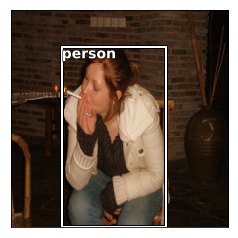

In [156]:
ax = show_img(ima)
draw_rect(ax,b)
draw_text(ax,b[:2],md2.classes[y[1][idx]])

We need one output activation for each class (for its probability) plus one for each bounding box coordinate. We'll use an extra linear layer this time, plus some dropout, to help us train a more flexible model.

In [157]:
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256, 4+len(cats))    
)
models = ConvnetBuilder(f_model, 0 , 0, 0,custom_head=head_reg4)
learn = ConvLearner(md,models)
learn.opt_fn=optim.Adam

We define a series of loss functions called detection loss functions. For bounding boxes we use L1 loss as that works well more than MSE which is L2 loss. for Categories we use cross entropy loss.
for the main loss function we add both the losses l1 and cross entropy. Since they have different scales one can dominate the other, so in debugger we check the values for few runs and find a constant that can balance it out. So we came with `*20` for cross entropy loss to balance out values from L1_loss.

in `detn_loss` function since target and dependant variable here is both bbox and categories/classes its a tuple and we use unpacking assignment to assign target to bb_t and c_t

for input we just split :4 for first four and 4: for last four in input.

Note the array has `[:,:4]` thats because first `:, ` is for number of batches dimension.

Also note while main loss is set on criteria for learn `learn.crit` which is `detn_loss` we also have l1_loss and accuracy and add them to learn.metrics to keep watching them during training

In [162]:
def detn_loss(input, target):
    bb_t,c_t = target
    bb_i,c_i = input[:,:4], input[:,4:]
    bb_i = torch.sigmoid(bb_i)*224 #to keep the boxes within the image (224 size)
    # After looking at these quantities separately first, a multiplier is chosen to make approximately equal
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20

def detn_l1(input,target):
    bb_t,_ = target
    bb_i = input[:,:4]
    bb_i = torch.sigmoid(bb_i)*224
    return F.l1_loss(V(bb_i),V(bb_t)).data

def detn_acc(input,target):
    _,c_t = target
    c_i =  input[:,4:]
    return accuracy(c_i,c_t)

learn.crit = detn_loss
learn.metrics = [detn_acc,detn_l1]

 97%|█████████▋| 31/32 [00:17<00:00,  1.80it/s, loss=304]

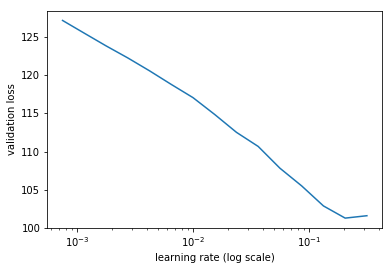

In [163]:
learn.lr_find()
learn.sched.plot()

In [164]:
lr=1e-2

In [165]:
learn.fit(lr,1,cycle_len=3,use_clr=(32,5)) # cyclic learning rate

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      73.157611  44.253213  0.79       30.762313 
    1      52.439918  36.958789  0.824      25.689313     
    2      43.44576   35.685739  0.824      24.756998     


[35.685739166259765, 0.8240000023841858, 24.756997985839845]

In [166]:
learn.save('reg1_0')

In [167]:
learn.freeze_to(-2)

In [168]:
lrs=np.array([lr/100,lr/10,lr])

 91%|█████████ | 29/32 [00:17<00:01,  1.63it/s, loss=97.2]

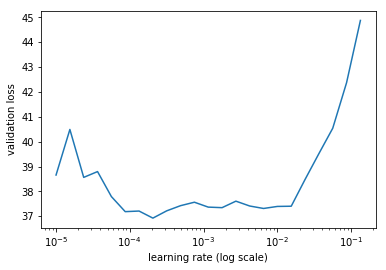

In [169]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [170]:
learn.fit(lrs/5, 1, cycle_len=5, use_clr=(32,10))

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      37.167451  33.743634  0.82       22.20323  
    1      31.079126  33.310679  0.81       21.200827     
    2      26.992975  31.312644  0.834      19.947983     
    3      23.602855  31.011691  0.828      19.552595     
    4      21.537131  30.685231  0.848      19.347612     


[30.685230590820314, 0.8480000009536743, 19.347612045288084]

In [171]:
learn.save('reg1_1')

In [172]:
learn.load('reg1_1')

In [173]:
learn.unfreeze()

In [174]:
learn.fit(lrs/10,1,cycle_len=10,use_clr=(32,10))

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      18.648119  31.776466  0.838      19.451485 
    1      18.326571  31.514337  0.824      19.463664     
    2      17.651962  32.320355  0.826      19.062921     
    3      16.835996  31.523192  0.828      19.98364      
    4      16.081733  31.207178  0.822      18.867247     
    5      15.043579  31.149438  0.828      18.769477     
    6      14.392409  30.49781   0.836      18.38725      
    7      13.725479  30.474704  0.834      18.412622     
    8      13.029779  30.864125  0.826      18.423557     
    9      12.80191   30.906686  0.826      18.275063     


[30.906685791015626, 0.8260000057220459, 18.275062522888184]

In [180]:
learn.fit(lrs/10,1,cycle_len=5,use_clr=(32,10))

epoch      trn_loss   val_loss   detn_acc   detn_l1       
    0      12.84511   32.686416  0.822      19.011179 
    1      13.420525  30.504652  0.842      18.07724      
    2      13.268154  31.134609  0.822      18.151188     
    3      12.876456  30.550174  0.83       17.96485      
    4      12.400908  29.967082  0.846      17.968956     


[29.96708200073242, 0.846000002861023, 17.96895608520508]

In [181]:
learn.save('reg1')

In [182]:
learn.load('reg1')

In [183]:
y = learn.predict()
x,_ = next(iter(md.val_dl))

In [184]:
from scipy.special import expit

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


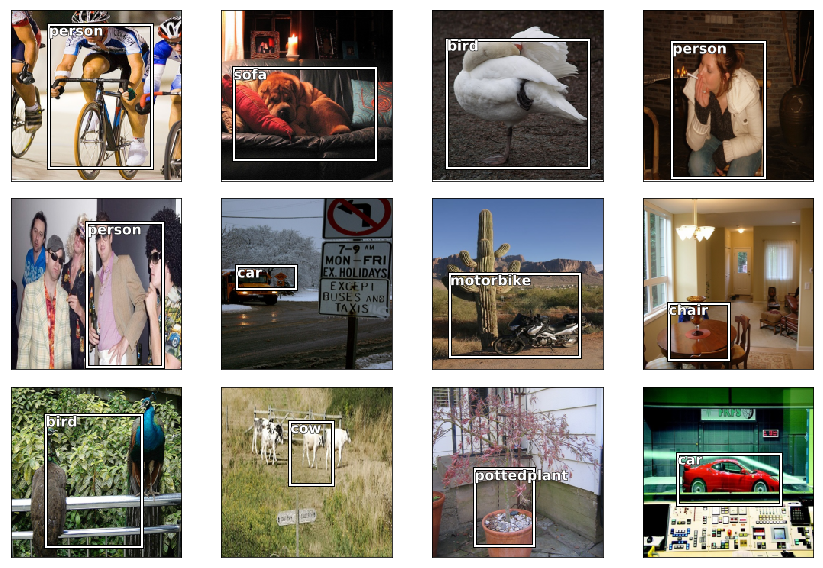

In [185]:
fig, axes = plt.subplots(3,4,figsize=(12,8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.ds.denorm(to_np(x))[i]
    bb = expit(y[i][:4])*224
    b = bb_hw(bb)
    c = np.argmax(y[i][4:])
    ax =  show_img(ima, ax=ax)
    draw_rect(ax,b)
    draw_text(ax,b[:2],md2.classes[c])
plt.tight_layout()

## End